# Imports and Device

In [ ]:
pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients, Saliency, ShapleyValueSampling

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create Data Loaders Using CIFAR-10

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:04<00:00, 40.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Initialize Model, Loss Function, and Optimizer

In [ ]:
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Train and Evaluate Model

In [ ]:
def train_model(num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch: {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

train_model()


Epoch: 1, Loss: 1.3805
Epoch: 2, Loss: 0.9769
Epoch: 3, Loss: 0.7989
Epoch: 4, Loss: 0.6747
Epoch: 5, Loss: 0.5767
Epoch: 6, Loss: 0.4833
Epoch: 7, Loss: 0.3994
Epoch: 8, Loss: 0.3257
Epoch: 9, Loss: 0.2591
Epoch: 10, Loss: 0.2100


In [ ]:
def evaluate_model():
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")

evaluate_model()

Accuracy: 76.79%


# Get and Visualize Attribution Scores from Explanation Methods

In [ ]:
def integrated_gradients_attri(model, image, label):
    ig = IntegratedGradients(model)
    attributions = ig.attribute(image.unsqueeze(0), target=label)
    return attributions

def saliency_attri(model, image, label):
    saliency = Saliency(model)
    attributions = saliency.attribute(image.unsqueeze(0), target=label)
    return attributions

def shapley_attri(model, image, label):
    shapley = ShapleyValueSampling(model)
    attributions = shapley.attribute(image.unsqueeze(0), target=label)
    return attributions

def display_images_explanations(image, true_label, predicted_label, attributions_ig, attributions_saliency, attributions_shapley):
    image = (image * 0.5) + 0.5
    image = image.detach().permute(1, 2, 0).cpu().numpy()
    image = np.clip(image, 0, 1)

    # Get attributions
    attributions_ig = attributions_ig.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
    attributions_saliency = attributions_saliency.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
    attributions_shapley = attributions_shapley.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

    # Normalize attributions on 0 to 1 scale for easier understanding
    attributions_ig = np.sum(np.abs(attributions_ig), axis=-1)
    attributions_ig -= attributions_ig.min()
    attributions_ig /= attributions_ig.max()

    attributions_saliency = np.sum(np.abs(attributions_saliency), axis=-1)
    attributions_saliency -= attributions_saliency.min()
    attributions_saliency /= attributions_saliency.max()

    attributions_shapley = np.sum(np.abs(attributions_shapley), axis=-1)
    attributions_shapley -= attributions_shapley.min()
    attributions_shapley /= attributions_shapley.max()

    fig, columns = plt.subplots(1, 4, figsize=(20, 5))

    # Plot original image
    columns[0].imshow(image)
    columns[0].set_title(f"Original Image\nTrue Label: {true_label}, Predicted Label: {predicted_label}")
    columns[0].axis("off")

    # Plot Integrated Gradients Image
    ig_img = columns[1].imshow(attributions_ig, cmap='hot', interpolation='nearest')
    columns[1].set_title("Integrated Gradients")
    columns[1].axis("off")
    plt.colorbar(ig_img, ax=columns[1])

    # Plot Saliency Map Image
    saliency_img = columns[2].imshow(attributions_saliency, cmap='hot', interpolation='nearest')
    columns[2].set_title("Saliency")
    columns[2].axis("off")
    plt.colorbar(saliency_img, ax=columns[2])

    # Plot Shapley Values Image
    shapley_img = columns[3].imshow(attributions_shapley, cmap='hot', interpolation='nearest')
    columns[3].set_title("Shapley Value Sampling")
    columns[3].axis("off")
    plt.colorbar(shapley_img, ax=columns[3])

    plt.tight_layout()
    plt.show()




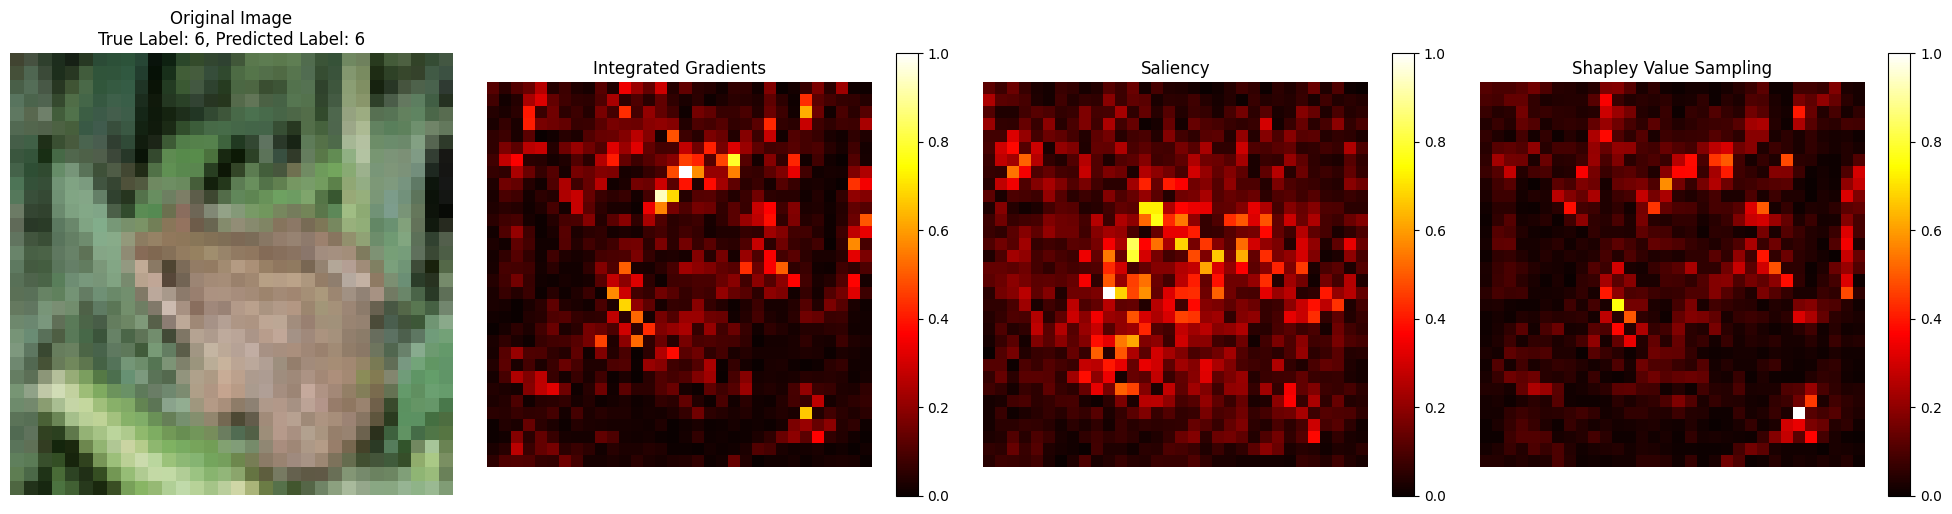

In [ ]:
# Visualize attributions for 5 images
images = []
labels = []

for i in range(5):
    img, label = test_dataset[i]
    images.append(img.to(device))
    labels.append(label)

model.eval()
with torch.set_grad_enabled(True):
    for img, true_label in zip(images, labels):
        img.requires_grad = True

        # Get model's predicted label
        predicted_label = model(img.unsqueeze(0)).argmax(dim=1).item()

        # Get attributions
        attributions_ig = integrated_gradients_attri(model, img, true_label)
        attributions_saliency = saliency_attri(model, img, true_label)
        attributions_shapley = shapley_attri(model, img, true_label)

        # Display image with both true and predicted labels
        display_images_explanations(img, true_label, predicted_label, attributions_ig, attributions_saliency, attributions_shapley)